In [1]:
import os
import pandas as pd
import janitor
import numpy as np
pd.set_option('display.max_columns', 100)

from utils.data_utils import fit_quantile_reg, fit_ols_reg
from utils.utils import save_mpl_fig
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", font_scale=1.05, style="whitegrid", palette="dark")
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

FIGSAVEDIR = "../figs"
DATAPATH = "../data/individual_browsing_data.csv"        

df_ind = (pd.read_csv(DATAPATH)
          # Normalize seconds to hours
          .assign(
              duration_adult=lambda df: df.duration_adult/3600,
              duration_nonadult=lambda df: df.duration_nonadult/3600,
          )
         )
df_ind

,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,rep,duration_adult,duration_nonadult,duration,prop_adult_duration,yes_visit_adults,race2,cohort,age,age2,educ2
0,200661421,1963,2,1,4,3,3,1,39,2,D,0.0,1728.0,1728.0,0.000000,0.0,0.000000,21.567222,77642.0,0.000000,0.0,1,1960,60,3600,4
1,200686597,1992,2,6,5,5,8,-1,48,3,NaN,243.0,3994.0,4237.0,5.735190,NaN,7.208889,65.054444,260148.0,9.975860,1.0,5,1990,31,961,4
2,200953869,1959,2,1,5,2,7,2,42,1,R,0.0,20.0,20.0,0.000000,1.0,0.000000,0.328333,1182.0,0.000000,0.0,1,1960,64,4096,4
3,201302005,1966,2,2,3,5,8,1,12,3,NaN,20.0,527.0,547.0,3.656307,NaN,1.712778,6.626389,30021.0,20.538956,1.0,2,1970,57,3249,3
4,201590505,1977,1,4,5,3,3,1,6,4,D,11.0,11075.0,11086.0,0.099224,0.0,0.118889,106.314722,383161.0,0.111702,1.0,4,1980,46,2116,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1802885,1935,1,1,6,4,5,2,12,3,R,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1,1940,88,7744,4
1196,1809723,1943,1,1,2,1,1,1,51,3,D,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1,1940,80,6400,2
1197,1827351,1947,1,1,5,3,4,1,31,2,I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1950,76,5776,4
1198,1924249,1980,1,7,4,2,7,2,6,4,R,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,5,1980,43,1849,4


In [2]:
quantiles = np.arange(0.05, 1, 0.05)
quantiles

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

### Visits to adult

In [3]:
outcome = "visits_adult"
savepath = "quantile_reg_nonzero_visits_adult"

In [4]:
quantile_results = [
    fit_quantile_reg(y=outcome, x="rep", quantile=quantile, df=df_ind.query(f"{outcome}>0"))
    for quantile in quantiles
]

quantile_results = pd.DataFrame(
    quantile_results, columns=["quantile", "intercept", "estimate", "ll", "hl", "tstat", "pval", "obs"]
)
quantile_results

,quantile,intercept,estimate,ll,hl,tstat,pval,obs
0,0.05,2.000000,1.000008,-19.690359,21.690375,0.095505,0.924042,151.0
1,0.10,3.000000,2.000000,-22.042345,26.042345,0.164378,0.869657,151.0
2,0.15,4.000067,1.999934,-23.350086,27.349954,0.155893,0.876328,151.0
3,0.20,5.999999,4.000001,-25.198762,33.198763,0.270698,0.786998,151.0
4,0.25,6.000005,4.999996,-26.197417,36.197409,0.316695,0.751918,151.0
5,0.30,10.000000,5.000000,-28.033561,38.033561,0.299092,0.765287,151.0
6,0.35,11.999999,26.000000,-6.479830,58.479831,1.581792,0.115817,151.0
7,0.40,14.999995,33.000004,-1.000685,67.000694,1.917857,0.057042,151.0
8,0.45,17.000006,43.999994,8.774525,79.225462,2.468230,0.014709,151.0
9,0.50,26.000000,50.966146,14.336768,87.595524,2.749426,0.006709,151.0


In [5]:
# (fold cell) Standard graph opts
opts_connected_line = {
    "linewidth":2,
    "markersize":7,
    "markerfacecolor":"0",
    "markeredgecolor":"0",
    "color":".4",
}
opts_fillbetween = {
    "color":".7",
    "zorder":1,
    "alpha":.8,
}
opts_0yline = {
    "color":"maroon",
    "alpha":.6,
    "linewidth":2,
    "zorder":1,
}

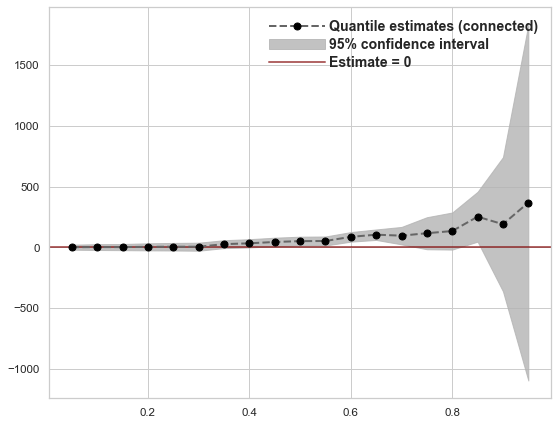

In [6]:
# (fold cell) plot
scale = 0.9
fig, ax = plt.subplots(figsize=(10 * scale, 8 * scale), facecolor="white")

y = "estimate"
x = "quantile"
plt.plot(
    quantile_results[x],
    quantile_results[y],
    "o--",
    **opts_connected_line
)
plt.fill_between(
    quantile_results[x],
    quantile_results["ll"],
    quantile_results["hl"],
    **opts_fillbetween
)
plt.axhline(y=0, **opts_0yline)

# Custom Legend
quantile_estimates = mlines.Line2D([], [], 
                                   marker='o', ls="--",
                                   **opts_connected_line,
                                   label='Quantile estimates (connected)',
                                  )
ci = mpatches.Patch(**opts_fillbetween, label='95% confidence interval')
yline0 = mlines.Line2D([], [], 
                       **opts_0yline,
                       label="Estimate = 0"
                      )
custom_legend = plt.legend(
    handles=[quantile_estimates, ci, yline0], 
    handlelength=4, 
    handletextpad=.3,
    labelspacing=.3,
    frameon=False,
    prop={'weight':'bold', "size":14},
    loc="best",
)
save_mpl_fig(os.path.join(FIGSAVEDIR, savepath))

### Proportion visits to adult

In [7]:
outcome = "prop_adult_visits"
savepath = "quantile_reg_nonzero_proportion_visits_adult"

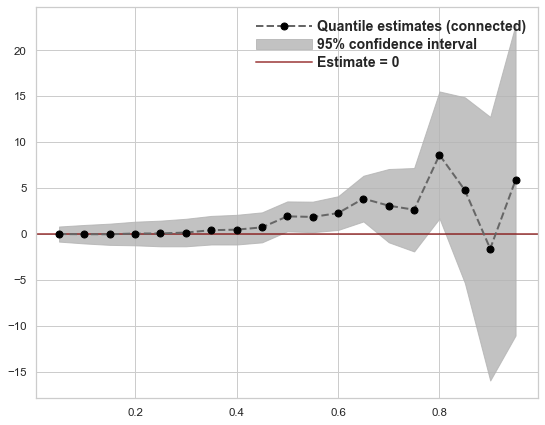

In [8]:
# (fold cell) plot
quantile_results = [
    fit_quantile_reg(y=outcome, x="rep", quantile=quantile, df=df_ind.query(f"{outcome}>0"))
    for quantile in quantiles
]

quantile_results = pd.DataFrame(
    quantile_results, columns=["quantile", "intercept", "estimate", "ll", "hl", "tstat", "pval", "obs"]
)


scale = 0.9
fig, ax = plt.subplots(figsize=(10 * scale, 8 * scale), facecolor="white")

y = "estimate"
x = "quantile"
plt.plot(
    quantile_results[x],
    quantile_results[y],
    "o--",
    **opts_connected_line
)
plt.fill_between(
    quantile_results[x],
    quantile_results["ll"],
    quantile_results["hl"],
    **opts_fillbetween
)
plt.axhline(y=0, **opts_0yline)

# Custom Legend
quantile_estimates = mlines.Line2D([], [], 
                                   marker='o', ls="--",
                                   **opts_connected_line,
                                   label='Quantile estimates (connected)',
                                  )
ci = mpatches.Patch(**opts_fillbetween, label='95% confidence interval')
yline0 = mlines.Line2D([], [], 
                       **opts_0yline,
                       label="Estimate = 0"
                      )
custom_legend = plt.legend(
    handles=[quantile_estimates, ci, yline0], 
    handlelength=4, 
    handletextpad=.3,
    labelspacing=.3,
    frameon=False,
    prop={'weight':'bold', "size":14},
    loc="best",
#     title_fontproperties={'weight':'bold', 'size':14},
)
save_mpl_fig(os.path.join(FIGSAVEDIR, savepath))

### Duration on adult

In [9]:
outcome = "duration_adult"
savepath = "quantile_reg_nonzero_duration_adult"

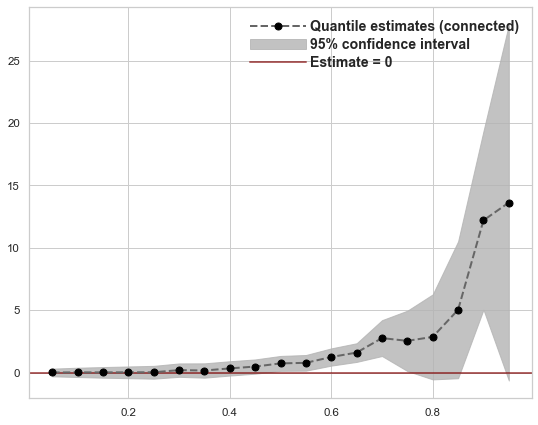

In [10]:
# (fold cell) plot
quantile_results = [
    fit_quantile_reg(y=outcome, x="rep", quantile=quantile, df=df_ind.query(f"{outcome}>0"))
    for quantile in quantiles
]

quantile_results = pd.DataFrame(
    quantile_results, columns=["quantile", "intercept", "estimate", "ll", "hl", "tstat", "pval", "obs"]
)


scale = 0.9
fig, ax = plt.subplots(figsize=(10 * scale, 8 * scale), facecolor="white")

y = "estimate"
x = "quantile"
plt.plot(
    quantile_results[x],
    quantile_results[y],
    "o--",
    **opts_connected_line
)
plt.fill_between(
    quantile_results[x],
    quantile_results["ll"],
    quantile_results["hl"],
    **opts_fillbetween
)
plt.axhline(y=0, **opts_0yline)

# Custom Legend
quantile_estimates = mlines.Line2D([], [], 
                                   marker='o', ls="--",
                                   **opts_connected_line,
                                   label='Quantile estimates (connected)',
                                  )
ci = mpatches.Patch(**opts_fillbetween, label='95% confidence interval')
yline0 = mlines.Line2D([], [], 
                       **opts_0yline,
                       label="Estimate = 0"
                      )
custom_legend = plt.legend(
    handles=[quantile_estimates, ci, yline0], 
    handlelength=4, 
    handletextpad=.3,
    labelspacing=.3,
    frameon=False,
    prop={'weight':'bold', "size":14},
    loc="best",
#     title_fontproperties={'weight':'bold', 'size':14},
)
save_mpl_fig(os.path.join(FIGSAVEDIR, savepath))

### Proportion duration on adult

In [11]:
outcome = "prop_adult_duration"
savepath = "quantile_reg_nonzero_proportion_duration_adult"

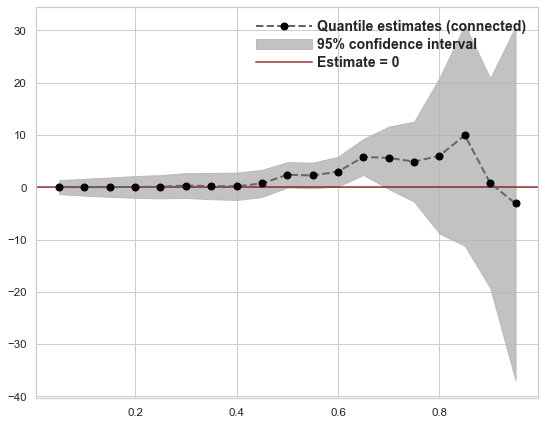

In [12]:
# (fold cell) plot
quantile_results = [
    fit_quantile_reg(y=outcome, x="rep", quantile=quantile, df=df_ind.query(f"{outcome}>0"))
    for quantile in quantiles
]

quantile_results = pd.DataFrame(
    quantile_results, columns=["quantile", "intercept", "estimate", "ll", "hl", "tstat", "pval", "obs"]
)


scale = 0.9
fig, ax = plt.subplots(figsize=(10 * scale, 8 * scale), facecolor="white")

y = "estimate"
x = "quantile"
plt.plot(
    quantile_results[x],
    quantile_results[y],
    "o--",
    **opts_connected_line
)
plt.fill_between(
    quantile_results[x],
    quantile_results["ll"],
    quantile_results["hl"],
    **opts_fillbetween
)
plt.axhline(y=0, **opts_0yline)

# Custom Legend
quantile_estimates = mlines.Line2D([], [], 
                                   marker='o', ls="--",
                                   **opts_connected_line,
                                   label='Quantile estimates (connected)',
                                  )
ci = mpatches.Patch(**opts_fillbetween, label='95% confidence interval')
yline0 = mlines.Line2D([], [], 
                       **opts_0yline,
                       label="Estimate = 0"
                      )
custom_legend = plt.legend(
    handles=[quantile_estimates, ci, yline0], 
    handlelength=4, 
    handletextpad=.3,
    labelspacing=.3,
    frameon=False,
    prop={'weight':'bold', "size":14},
    loc="best",
#     title_fontproperties={'weight':'bold', 'size':14},
)
save_mpl_fig(os.path.join(FIGSAVEDIR, savepath))